# ⬇️ Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pathlib import Path
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


# ✅ Downloading the data

region (department) exceptions :
- 20 not existing ->2A and 2B
- 57, 67, 68 -> no data
- 69 -> 69D and 59M

In [2]:
## list all the number of regions we can download
regions = list(np.arange(1,96))
# regions = list(map(str, regions))
regions = list(np.delete(regions, [20-1, 57-1, 67-1, 68-1]))
regions = regions + ['2A', '2B']
print(regions)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, '2A', '2B']


In [3]:
# download all csv files

# from pathlib import Path

for index, num in enumerate(regions):
    if index < 9 :
        url = f'https://dvf-api.data.gouv.fr/dvf/csv/?dep=0{num}'
    else :
        url = f'https://dvf-api.data.gouv.fr/dvf/csv/?dep={num}'

    path = Path(f'../raw_data/dvf_{num}.csv')

    if not path.is_file():
        df = pd.read_csv(url)
        df.to_csv(path)
        print(f'Downloaded region n° {num} 💪')

    else:
        print(f'region n° {num} is already downloaded ! 🚀')


region n° 1 is already downloaded ! 🚀
region n° 2 is already downloaded ! 🚀
region n° 3 is already downloaded ! 🚀
region n° 4 is already downloaded ! 🚀
region n° 5 is already downloaded ! 🚀
region n° 6 is already downloaded ! 🚀
region n° 7 is already downloaded ! 🚀
region n° 8 is already downloaded ! 🚀
region n° 9 is already downloaded ! 🚀
region n° 10 is already downloaded ! 🚀
region n° 11 is already downloaded ! 🚀
region n° 12 is already downloaded ! 🚀
region n° 13 is already downloaded ! 🚀
region n° 14 is already downloaded ! 🚀
region n° 15 is already downloaded ! 🚀
region n° 16 is already downloaded ! 🚀
region n° 17 is already downloaded ! 🚀
region n° 18 is already downloaded ! 🚀
region n° 19 is already downloaded ! 🚀
region n° 21 is already downloaded ! 🚀
region n° 22 is already downloaded ! 🚀
region n° 23 is already downloaded ! 🚀
region n° 24 is already downloaded ! 🚀
region n° 25 is already downloaded ! 🚀
region n° 26 is already downloaded ! 🚀
region n° 27 is already downloaded

In [38]:
df = pd.DataFrame()
for num in regions[1:3]:
    df = pd.concat([df, pd.read_csv(f'../raw_data/dvf_{num}.csv')])
    print(f'Concatenated region n°{num} to the df 🌍')

Concatenated region n°2 to the df 🌍
Concatenated region n°3 to the df 🌍


In [ ]:
# # concat all csv files in 1 big dataframe --> too big for the kernel -> VertexAI
# df = pd.DataFrame()
# for num in regions:
#     df = pd.concat([df, pd.read_csv(f'raw_data/dvf_{num}.csv')])
#     print(f'Concatenated region n°{num} to the df 🌍')

> To concat everything without killing the kernel --> VertexAI

In [6]:
# df.shape
# # (19575540, 42)

In [ ]:
# ### save full df raw as 1 csv
# df.to_csv(f'raw_data/dvf_full_raw.csv')

In [ ]:
# ## to clean all the data

# from data import clean_data
# df_cleaned = clean_data(df)
# df_cleaned.shape #(1029674, 11)

In [ ]:
# df_cleaned.to_csv(f'raw_data/dvf_full_cleaned.csv')

In [100]:
# Get the data from the csv file
dvf_full_raw = pd.read_csv('../raw_data/dvf_full_raw.csv')

dvf_full_raw.shape

(1237705, 43)

In [39]:
# Get the data from the csv file
df_cleaned = pd.read_csv('../raw_data/dvf_full_cleaned.csv')

df_cleaned.shape

(1029674, 12)

In [99]:
df_cleaned.head()

,Unnamed: 0,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,longitude,latitude
0,35,2022-06-30,built,200000.0,1000,1053,1,Appartement,155.0,4.0,5.224279,46.205820
1,45,2022-06-10,built,252500.0,1630,1401,1,Appartement,49.0,2.0,5.997840,46.253728
2,59,2022-06-21,built,122500.0,1000,1053,1,Appartement,51.0,1.0,5.226737,46.205375
3,71,2022-06-20,built,188600.0,1000,1053,1,Appartement,75.0,3.0,5.229836,46.204833
4,77,2022-06-20,built,188600.0,1000,1053,1,Appartement,109.0,5.0,5.229836,46.204833


# 🔎 Exploring cleaned data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

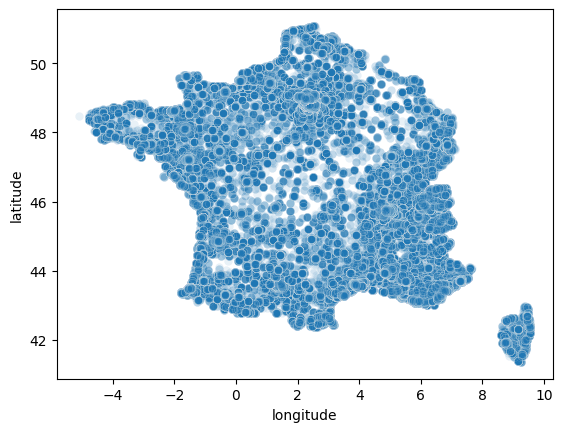

In [41]:
sns.scatterplot(df_cleaned.longitude, df_cleaned.latitude, alpha=0.1)

In [7]:
df_dvf = pd.read_csv('../raw_data/dvf_93.csv')

df_dvf.shape

(271360, 42)

# 🔎 Exploring 1 region

In [8]:
df_dvf.duplicated().sum()

0

In [9]:
df_dvf['nature_mutation'].unique()

array(["Vente en l'état futur d'achèvement", 'Vente', 'Echange',
       'Vente terrain à bâtir', 'Expropriation', 'Adjudication',
       'nature_mutation'], dtype=object)

In [10]:
df_dvf['nature_mutation'].value_counts()

Vente                                 193157
Vente en l'état futur d'achèvement     75039
Adjudication                            1366
Expropriation                            849
Echange                                  796
Vente terrain à bâtir                    148
nature_mutation                            5
Name: nature_mutation, dtype: int64

In [11]:
df_dvf.dtypes

Unnamed: 0                       int64
id_mutation                     object
date_mutation                   object
numero_disposition              object
nature_mutation                 object
valeur_fonciere                 object
adresse_numero                  object
adresse_suffixe                 object
adresse_nom_voie                object
adresse_code_voie               object
code_postal                     object
code_commune                    object
nom_commune                     object
code_departement                object
ancien_code_commune             object
ancien_nom_commune              object
id_parcelle                     object
ancien_id_parcelle              object
numero_volume                   object
lot1_numero                     object
lot1_surface_carrez             object
lot2_numero                     object
lot2_surface_carrez             object
lot3_numero                     object
lot3_surface_carrez             object
lot4_numero              

In [12]:
df_dvf.columns

Index(['Unnamed: 0', 'id_mutation', 'date_mutation', 'numero_disposition',
       'nature_mutation', 'valeur_fonciere', 'adresse_numero',
       'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie',
       'code_postal', 'code_commune', 'nom_commune', 'code_departement',
       'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle',
       'ancien_id_parcelle', 'numero_volume', 'lot1_numero',
       'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
       'lot3_numero', 'lot3_surface_carrez', 'lot4_numero',
       'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez',
       'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati',
       'nombre_pieces_principales', 'code_nature_culture', 'nature_culture',
       'code_nature_culture_speciale', 'nature_culture_speciale',
       'surface_terrain', 'longitude', 'latitude', 'section_prefixe'],
      dtype='object')

In [13]:
df_dvf.isnull().sum()

Unnamed: 0                           0
id_mutation                          0
date_mutation                        0
numero_disposition                   0
nature_mutation                      0
valeur_fonciere                   1627
adresse_numero                   28993
adresse_suffixe                 258562
adresse_nom_voie                 11072
adresse_code_voie                11072
code_postal                      11072
code_commune                         0
nom_commune                          0
code_departement                     0
ancien_code_commune             271355
ancien_nom_commune              271355
id_parcelle                          0
ancien_id_parcelle              271355
numero_volume                   269744
lot1_numero                      73453
lot1_surface_carrez             229403
lot2_numero                     226927
lot2_surface_carrez             259898
lot3_numero                     265832
lot3_surface_carrez             270521
lot4_numero              

In [14]:
df_dvf[['code_postal', 'code_commune', 'nom_commune']].isnull().sum()/len(df_dvf)

code_postal     0.040802
code_commune    0.000000
nom_commune     0.000000
dtype: float64

In [15]:
df_dvf['nombre_lots'].astype('str').value_counts()

1              153474
0               73453
2               38905
3                3585
4                1121
5                 356
6                 179
7                 120
9                  42
8                  35
10                 12
12                  7
17                  7
22                  6
11                  6
15                  5
nombre_lots         5
13                  5
25                  4
21                  3
14                  3
45                  3
33                  3
61                  2
44                  2
28                  2
19                  2
31                  2
23                  2
95                  1
34                  1
16                  1
20                  1
27                  1
49                  1
72                  1
150                 1
80                  1
Name: nombre_lots, dtype: int64

In [16]:
df_dvf['type_local'].unique()

array([nan, 'Dépendance', 'Appartement', 'Maison',
       'Local industriel. commercial ou assimilé', 'type_local'],
      dtype=object)

# 🔅 Preprocessing

## 🧹 Keep only useful columns and rows and translate

### Removing columns

In [17]:
keep_col =['date_mutation',
            'nature_mutation',
            'valeur_fonciere',
            'code_postal',
            'code_commune',
            'code_departement',
            'nombre_lots',
            'type_local',
            'surface_reelle_bati',
            'nombre_pieces_principales',
            'longitude',
            'latitude']
df_dvf = df_dvf[keep_col]

df_dvf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   date_mutation              271360 non-null  object
 1   nature_mutation            271360 non-null  object
 2   valeur_fonciere            269733 non-null  object
 3   code_postal                260288 non-null  object
 4   code_commune               271360 non-null  object
 5   code_departement           271360 non-null  object
 6   nombre_lots                271360 non-null  object
 7   type_local                 212434 non-null  object
 8   surface_reelle_bati        127260 non-null  object
 9   nombre_pieces_principales  212276 non-null  object
 10  longitude                  263977 non-null  object
 11  latitude                   263977 non-null  object
dtypes: object(12)
memory usage: 24.8+ MB


### Translate column-names

In [18]:
df_dvf.columns = ['date', 'built', 'price', 'postal_code',
                'city', 'region', 'number_of_units', 'property_type',
                'living_area', 'number_of_rooms',
                'longitude', 'latitude']

### Remove non-representative rows

In [19]:
df_dvf.shape

(271360, 12)

In [20]:
df_dvf['built'].unique()

array(["Vente en l'état futur d'achèvement", 'Vente', 'Echange',
       'Vente terrain à bâtir', 'Expropriation', 'Adjudication',
       'nature_mutation'], dtype=object)

In [21]:
df_dvf.shape

(271360, 12)

In [22]:
df_dvf['built'].unique()

array(["Vente en l'état futur d'achèvement", 'Vente', 'Echange',
       'Vente terrain à bâtir', 'Expropriation', 'Adjudication',
       'nature_mutation'], dtype=object)

We want to keep only :
- Houses and appartments
- Normal sales and off-plan sales
- Sales with only one unit

In [23]:
df_dvf['built'].unique()

array(["Vente en l'état futur d'achèvement", 'Vente', 'Echange',
       'Vente terrain à bâtir', 'Expropriation', 'Adjudication',
       'nature_mutation'], dtype=object)

In [24]:
print('Shape before the masks : ', df_dvf.shape)
print('Shape only normal sales', df_dvf[((df_dvf['built'] == "Vente") | (df_dvf['built'] == "Vente en l'état futur d'achèvement"))].shape)
print('Shape only 1 unit', df_dvf[((df_dvf['number_of_units'] == 1) | (df_dvf['number_of_units'] == '1'))].shape)
print('Shape only house and appartments', df_dvf[((df_dvf['property_type'] == 'Appartement') | (df_dvf['property_type'] == 'Maison'))].shape)

Shape before the masks :  (271360, 12)
Shape only normal sales (268196, 12)
Shape only 1 unit (153474, 12)
Shape only house and appartments (115664, 12)


In [25]:
df_useful = df_dvf[((df_dvf['built'] == "Vente") | (df_dvf['built'] == "Vente en l'état futur d'achèvement")) &
                    ((df_dvf['number_of_units'] == 1) | (df_dvf['number_of_units'] == '1')) &
                    ((df_dvf['property_type'] == 'Appartement') | (df_dvf['property_type'] == 'Maison'))]
df_useful.shape

(42903, 12)

In [26]:
## checking that the masks worked correctly
print(df_useful['built'].unique())
print(df_useful['number_of_units'].unique())
print(df_useful['property_type'].unique())


['Vente' "Vente en l'état futur d'achèvement"]
[1 '1']
['Maison' 'Appartement']


### Translating the values

In [27]:
trans_dict_built = {'Vente' : 'built',
                    'Vente en l’état futur d’achèvement' : 'off-plan'}
trans_dict_type = {'Appartement' : 'appartment',
                   'Maison' : 'house'}
df_useful= df_useful.replace({'built' : trans_dict_built,
                             'property type' : trans_dict_type})

In [28]:
# checking we didn't lose rows
df_useful.shape

(42903, 12)

## 🚮 Dropping duplicates and NaNs

In [29]:
df_useful.columns

Index(['date', 'built', 'price', 'postal_code', 'city', 'region',
       'number_of_units', 'property_type', 'living_area', 'number_of_rooms',
       'longitude', 'latitude'],
      dtype='object')

In [30]:
## dropping the column with number of units (only 1s)
df_useful = df_useful.drop(columns='number_of_units')

In [31]:
df_useful.columns

Index(['date', 'built', 'price', 'postal_code', 'city', 'region',
       'property_type', 'living_area', 'number_of_rooms', 'longitude',
       'latitude'],
      dtype='object')

In [32]:
## checking for NaN values
df_useful.isna().sum()
df_useful = df_useful.dropna()
df_useful.shape
df_useful = df_useful.drop_duplicates()
df_useful.shape

(34297, 11)

## 🦖 Changing everything to the right type

In [33]:
col_float = ['price', 'longitude', 'latitude', 'postal_code', 'living_area', 'number_of_rooms']
col_string = ['built','city', 'region','property_type']
col_date = ['date']
### Formating data types ####
df_useful[col_float] = df_useful[col_float].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('float64'))
df_useful[col_date]= df_useful[col_date].apply(lambda x: pd.to_datetime(x, errors='coerce'))

df_useful.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34297 entries, 56 to 271358
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             34297 non-null  datetime64[ns]
 1   built            34297 non-null  object        
 2   price            34297 non-null  float64       
 3   postal_code      34297 non-null  float64       
 4   city             34297 non-null  object        
 5   region           34297 non-null  object        
 6   property_type    34297 non-null  object        
 7   living_area      34297 non-null  float64       
 8   number_of_rooms  34297 non-null  float64       
 9   longitude        34297 non-null  float64       
 10  latitude         34297 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 3.1+ MB


In [34]:
df_useful.shape

(34297, 11)

In [35]:
df_useful.head()

,date,built,price,postal_code,city,region,property_type,living_area,number_of_rooms,longitude,latitude
56,2019-01-09,built,200000.0,93320.0,93057,93,Maison,47.0,2.0,2.512376,48.907392
58,2019-01-03,built,285000.0,93310.0,93061,93,Appartement,43.0,2.0,2.404440,48.888226
59,2019-01-03,built,285000.0,93310.0,93061,93,Appartement,47.0,3.0,2.404440,48.888226
64,2019-01-08,built,285000.0,93500.0,93055,93,Appartement,63.0,3.0,2.397210,48.904147
66,2019-01-04,built,62000.0,93140.0,93010,93,Appartement,15.0,1.0,2.479755,48.900072


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

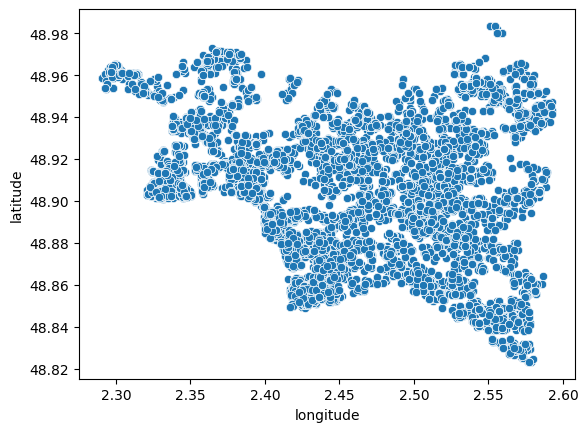

In [36]:
# import folium
# m = folium.Map(location = [-33.8, 151.2], tiles ='OpenStreetMap', zoom_start=11)
import seaborn as sns
sns.scatterplot(x = df_useful['longitude'], y = df_useful['latitude'])

## ✨ data.py : clean_data + download_csv

# 🤓 Feature engineering

# 🐧 Modelling

## 🔎 Exploring some more

In [43]:
df_cleaned.columns

Index(['Unnamed: 0', 'date', 'built', 'price', 'postal_code', 'city', 'region',
       'property_type', 'living_area', 'number_of_rooms', 'longitude',
       'latitude'],
      dtype='object')

In [63]:
# df_cleaned.shape # (1029674, 12)

(1029674, 12)

In [62]:
# df_cleaned[mask_price].shape # (1027158, 12)

(1027158, 12)

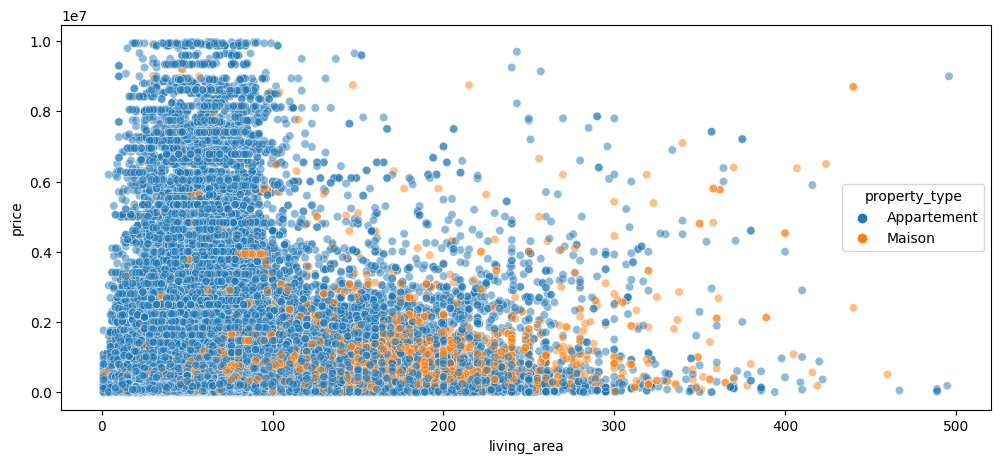

In [53]:
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
mask_price = df_cleaned['price']<10000000 #smaller than 10 milion
mask_area = df_cleaned['living_area']<500 # smaller than 500 sq meters
df_without_outliers = df_cleaned[mask_price & mask_area]

# Plot Living area vs Sale price
plt.figure(figsize = (12,5))
sns.scatterplot(df_without_outliers['living_area'], df_without_outliers['price'],hue = df_without_outliers['property_type'],alpha = 0.5)
plt.show()

In [54]:
df_without_outliers['property_type'].value_counts()

Appartement    950458
Maison          76673
Name: property_type, dtype: int64

<AxesSubplot:>

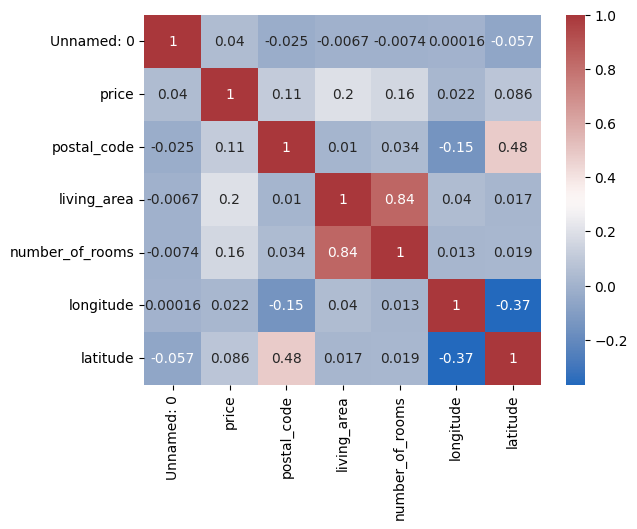

In [55]:
sns.heatmap(df_without_outliers.corr(), cmap = 'vlag', annot = True)

In [66]:
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027131 entries, 0 to 1029673
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1027131 non-null  int64  
 1   date             1027131 non-null  object 
 2   built            1027131 non-null  object 
 3   price            1027131 non-null  float64
 4   postal_code      1027131 non-null  int64  
 5   city             1027131 non-null  object 
 6   region           1027131 non-null  object 
 7   property_type    1027131 non-null  object 
 8   living_area      1027131 non-null  float64
 9   number_of_rooms  1027131 non-null  float64
 10  longitude        1027131 non-null  float64
 11  latitude         1027131 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 101.9+ MB


In [ ]:
##### we have to scale data first ######

## 🐟 Naive baseline model

In [69]:
X = df_without_outliers.drop(columns=['price'])
y = df_without_outliers['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
mean_price = y_train.mean()
print(f"The mean price of {round(mean_price)}")

median_price = y_train.median()
print(f"The median price of {round(median_price)}")

The mean price of 246383
The median price of 162000


In [91]:
mean_error = y_test - mean_price
rmse_mean = ((mean_error**2).mean())**(1/2)
print(f'The rmse when always predicting the mean : {round(rmse_mean)} €.')

The rmse when always predicting the mean : 470419 €.


In [92]:
median_error = y_test - median_price
rmse_median = ((median_error**2).mean())**(1/2)
print(f'The rmse when always predicting the median : {round(rmse_median)} €.')

The rmse when always predicting the median : 478091 €.


## ⚖️ Importing the preprocessed files Andrea made : 

In [128]:
X_train_preproc = pd.read_pickle('../raw_data/X_train_preproc.pickle')
X_test_preproc = pd.read_pickle('../raw_data/X_test_preproc.pickle')
y_train = pd.read_pickle('../raw_data/y_train.pickle')
y_test = pd.read_pickle('../raw_data/y_test.pickle')

In [130]:
print(X_train_preproc.shape, X_test_preproc.shape)
print(y_train.shape, y_test.shape)

(720771, 8) (308903, 8)
(720771, 1) (308903, 1)


## 🐸 Model

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


In [133]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()

model_rfr.fit(X_train_preproc, y_train)
y_pred = model_rfr.predict(X_test_preproc)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
print(f'Root Mean Squared Error: {rmse}')
print( 'Train score:', model_rfr.score(X_test_preproc, y_test))
print('Cross val score mean', cross_val_score(model_rfr, X_train_preproc, y_train, cv = 5).mean())

: 